### Data Pre-Processing for Spotify Buddies

This notebook has most of the data preparation process for initiating our work on Spotify Buddies data. This is how the data would be originated in the business, and this process is not strictly part of our data pipeline.

### Part I: processing MPD and ENTP separetely and create unique song_ids between the two datasets

In [1]:
import json
from pathlib import Path

import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.sparse import csr_matrix, issparse, vstack
import numpy as np

In [ ]:
MPD_FOLDER = "/content/drive/My Drive/datasets/mpd_data"

In [ ]:
# Replace with the actual path to your parquet file
parquet_path = '/content/drive/My Drive/datasets/entp_data/merged_df.parquet'
df = pl.read_parquet(parquet_path)

# Show first few rows
df.head()

user_id,songs_id,songs_count,title,release,artist_name,year,aug_song_id
str,str,i64,str,str,str,i64,str
"""b80344d063b5ccb3212f76538f3d9e…","""SOAKIMP12A8C130995""",1,"""The Cove""","""Thicker Than Water""","""Jack Johnson""",0,"""The CoveJack Johnson"""
"""b80344d063b5ccb3212f76538f3d9e…","""SOAPDEY12A81C210A9""",1,"""Nothing from Nothing""","""To Die For""","""Billy Preston""",1974,"""Nothing from NothingBilly Pres…"
"""b80344d063b5ccb3212f76538f3d9e…","""SOBBMDR12A8C13253B""",2,"""Entre Dos Aguas""","""Flamenco Para Niños""","""Paco De Lucia""",1976,"""Entre Dos AguasPaco De Lucia"""
"""b80344d063b5ccb3212f76538f3d9e…","""SOBFNSP12AF72A0E22""",1,"""Under Cold Blue Stars""","""Under Cold Blue Stars""","""Josh Rouse""",2002,"""Under Cold Blue StarsJosh Rous…"
"""b80344d063b5ccb3212f76538f3d9e…","""SOBFOVM12A58A7D494""",1,"""Riot Radio (Soundtrack Version…","""Nick & Norah's Infinite Playli…","""The Dead 60s""",0,"""Riot Radio (Soundtrack Version…"


In [ ]:
import os
import json
import pandas as pd
from tqdm import tqdm


# Load ENTP songs from merged_df
def extract_entp_songs(merged_df):
    entp_keys = set()
    for title, artist in zip(df['title'], df['artist_name']):
        if pd.notnull(title) and pd.notnull(artist):
            key = f"{title.strip().lower()}@@{artist.strip().lower()}"
            entp_keys.add(key)
    return entp_keys

In [ ]:
# Load MPD songs from JSON files


def extract_mpd_songs(mpd_folder):
    mpd_keys = set()
    files = [f for f in os.listdir(MPD_FOLDER) if f.endswith('.json')]

    for file in tqdm(files, desc="Processing MPD slices"):
        with open(os.path.join(MPD_FOLDER, file), 'r', encoding='utf-8') as f:
            try:
              data = json.load(f)
              for playlist in data['playlists']:
                  for track in playlist['tracks']:
                      title = track.get('track_name', '').strip().lower()
                      artist = track.get('artist_name', '').strip().lower()
                      if title and artist:
                          key = f"{title}@@{artist}"
                          mpd_keys.add(key)
            except:
              pass
    return mpd_keys

# Combine and assign unique song IDs
def build_song_id_mapping(merged_df, MPD_FOLDER):
    entp_keys = extract_entp_songs(merged_df)
    mpd_keys = extract_mpd_songs(MPD_FOLDER)
    all_song_keys = sorted(entp_keys | mpd_keys)

    song_to_id = {song: idx for idx, song in enumerate(all_song_keys)}
    return song_to_id

In [ ]:
# Generate song-to-ID mapping
song_to_id = build_song_id_mapping(df, "mpd_slices/")

print(f"Total unique songs: {len(song_to_id)}")

Processing MPD slices: 100%|██████████| 947/947 [17:56<00:00,  1.14s/it]


Total unique songs: 2397197


In [ ]:
import pickle

# Save
with open("/content/drive/MyDrive/datasets/song_to_id.pkl", "wb") as f:
    pickle.dump(song_to_id, f)

# Load later
with open("/content/drive/MyDrive/datasets/song_to_id.pkl", "rb") as f:
    song_to_id = pickle.load(f)


### Part 2: Users and playlists sparse matrices

The goal of this part is to obtain the amount of matching songs between each user and each playlist. This is a 1M*1M grid, but each user and playlist have X and Y number of songs, so it's a very large operation. We use sparse matrices and slices to make it manageable and more efficient.

In [ ]:
# STEP 2: Build User Sparse Matrix

import pandas as pd
import pickle
import numpy as np
from scipy.sparse import csr_matrix

# === Load ENTP Parquet with only needed columns ===
merged_df = pd.read_parquet(
    "/content/drive/My Drive/datasets/entp_data/merged_df.parquet",
    columns=["user_id", "title", "artist_name"]
)

# === Load song_to_id mapping ===
with open("/content/drive/My Drive/datasets/song_to_id.pkl", "rb") as f:
    song_to_id = pickle.load(f)

# === Build user matrix function ===
def build_user_matrix(merged_df, song_to_id):
    print("Building user matrix...")

    user_ids = merged_df['user_id'].unique()
    user_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
    n_users = len(user_to_idx)
    n_songs = len(song_to_id)

    print(f"Total users: {n_users}, Total songs: {n_songs}")

    data, row_indices, col_indices = [], [], []

    for row in merged_df.itertuples(index=False):
        if pd.notnull(row.title) and pd.notnull(row.artist_name):
            song_key = f"{row.title.strip().lower()}@@{row.artist_name.strip().lower()}"
            if song_key in song_to_id:
                user_idx = user_to_idx[row.user_id]
                song_idx = song_to_id[song_key]

                row_indices.append(user_idx)
                col_indices.append(song_idx)
                data.append(1)

    user_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(n_users, n_songs))

    return user_matrix, user_to_idx

In [ ]:
# Build user sparse matrix
user_matrix, user_to_idx = build_user_matrix(merged_df, song_to_id)

# Confirm shape
print("User matrix built:", user_matrix.shape)

# Save user_matrix
with open("/content/drive/My Drive/datasets/user_matrix.pkl", "wb") as f:
    pickle.dump(user_matrix, f)

# Save user_to_idx
with open("/content/drive/My Drive/datasets/user_to_idx.pkl", "wb") as f:
    pickle.dump(user_to_idx, f)

Building user matrix...
Total users: 1019318, Total songs: 2397197
User matrix built: (1019318, 2397197)


In [ ]:
# Load files (if needed)
# with open("/content/drive/My Drive/datasets/user_matrix.pkl", "rb") as f:
#     user_matrix = pickle.load(f)

# with open("/content/drive/My Drive/datasets/user_to_idx.pkl", "rb") as f:
#     user_to_idx = pickle.load(f)

In [ ]:
# Step 3: playlist sparse matrix builder function

import os
import json
import pickle
from tqdm import tqdm
from scipy.sparse import csr_matrix

def build_playlist_matrix(mpd_folder, song_to_id):
    print("Building playlist matrix...")

    data, row_indices, col_indices = [], [], []
    playlist_to_idx = {}
    playlist_counter = 0
    n_songs = len(song_to_id)

    json_files = [f for f in os.listdir(MPD_FOLDER) if f.endswith('.json')]

    for file in tqdm(json_files, desc="Processing MPD slices"):
      try:

        with open(os.path.join(mpd_folder, file), "r", encoding="utf-8") as f:
            slice_data = json.load(f)

            for playlist in slice_data["playlists"]:
                pid = playlist["pid"]
                playlist_to_idx[pid] = playlist_counter

                for track in playlist["tracks"]:
                    title = track.get("track_name", "").strip().lower()
                    artist = track.get("artist_name", "").strip().lower()
                    if title and artist:
                        key = f"{title}@@{artist}"
                        if key in song_to_id:
                            song_idx = song_to_id[key]

                            row_indices.append(playlist_counter)
                            col_indices.append(song_idx)
                            data.append(1)

                playlist_counter += 1

      except json.JSONDecodeError as e:
          print(f"Skipping file due to JSON error: {file} — {e}")
          continue

    playlist_matrix = csr_matrix((data, (row_indices, col_indices)), shape=(playlist_counter, n_songs))
    return playlist_matrix, playlist_to_idx



In [ ]:
# Step 3: generate the playlist sparse matrix

# Load song_to_id again (if not already in memory)
with open("/content/drive/My Drive/datasets/song_to_id.pkl", "rb") as f:
    song_to_id = pickle.load(f)

# Set path to your MPD slices
mpd_folder = "/content/drive/My Drive/datasets/mpd_data/"

# Build matrix
playlist_matrix, playlist_to_idx = build_playlist_matrix(mpd_folder, song_to_id)
print("Playlist matrix built:", playlist_matrix.shape)

# Save results
with open("/content/drive/My Drive/datasets/playlist_matrix.pkl", "wb") as f:
    pickle.dump(playlist_matrix, f)

with open("/content/drive/My Drive/datasets/playlist_to_idx.pkl", "wb") as f:
    pickle.dump(playlist_to_idx, f)

Building playlist matrix...


Processing MPD slices: 100%|██████████| 947/947 [16:09<00:00,  1.02s/it]

Skipping file due to JSON error: mpd.slice.0-999.json — Expecting ',' delimiter: line 21320 column 68 (char 1048597)


Playlist matrix built: (946000, 2397197)


In [ ]:
#Step 3: load files (if required)
# # Load files
# merged_df = pd.read_parquet(
#     "/content/drive/My Drive/datasets/entp_data/merged_df.parquet",
#     columns=["user_id", "title", "artist_name"]
# )
# with open("/content/drive/My Drive/datasets/song_to_id.pkl", "rb") as f:
#     song_to_id = pickle.load(f)

# # Build matrix
# user_matrix, user_to_idx = build_user_matrix(merged_df, song_to_id)
# print("User matrix built:", user_matrix.shape)

In [ ]:
# Step 4: compute matches between both matrics (user and playlists)

# === Load matrices ===
with open("/content/drive/My Drive/datasets/user_matrix.pkl", "rb") as f:
    user_matrix = pickle.load(f)

with open("/content/drive/My Drive/datasets/playlist_matrix.pkl", "rb") as f:
    playlist_matrix = pickle.load(f)


# === Multiply to get user–playlist overlaps ===
print("Computing overlap matrix...")
playlist_matrix_T = playlist_matrix.transpose().tocsr()
overlap_matrix = user_matrix.dot(playlist_matrix_T)  # shape: (n_users, n_playlists)

print("Done! Overlap matrix shape:", overlap_matrix.shape)


with open("/content/drive/My Drive/datasets/overlap_matrix.pkl", "wb") as f:
    pickle.dump(overlap_matrix, f)

KeyboardInterrupt: 

In [ ]:
# Step 4: compute matches between both matrics (user and playlists) with batched multiplication


# === Load matrices ===
with open("/content/drive/My Drive/datasets/user_matrix.pkl", "rb") as f:
    user_matrix = pickle.load(f)

with open("/content/drive/My Drive/datasets/playlist_matrix.pkl", "rb") as f:
    playlist_matrix = pickle.load(f)

playlist_matrix_T = playlist_matrix.transpose().tocsr()

# === Set batch parameters ===
batch_size = 10000
n_users = user_matrix.shape[0]

print("Starting streaming batched dot product...")

for start in range(0, n_users, batch_size):
    end = min(start + batch_size, n_users)
    batch = user_matrix[start:end]

    print(f"Processing users {start} to {end}...")

    batch_overlap = batch.dot(playlist_matrix_T)

    batch_file = f"/content/drive/My Drive/datasets/overlap_batches/overlap_{start}_{end}.pkl"
    with open(batch_file, "wb") as f:
        pickle.dump(batch_overlap, f)

print("✅ Done! All batches saved to disk.")

KeyboardInterrupt: 

In [ ]:
import os
import pickle
from scipy.sparse import csr_matrix

# === Load matrices ===
with open("/content/drive/My Drive/datasets/user_matrix.pkl", "rb") as f:
    user_matrix = pickle.load(f)

with open("/content/drive/My Drive/datasets/playlist_matrix.pkl", "rb") as f:
    playlist_matrix = pickle.load(f)

playlist_matrix_T = playlist_matrix.transpose().tocsr()

# === Set batch parameters ===
batch_size = 10000
n_users = user_matrix.shape[0]

output_dir = "/content/drive/My Drive/datasets/overlap_batches"
os.makedirs(output_dir, exist_ok=True)

print("Starting streaming batched dot product...")

for start in range(0, n_users, batch_size):
    end = min(start + batch_size, n_users)
    batch_file = os.path.join(output_dir, f"overlap_{start}_{end}.pkl")

    if os.path.exists(batch_file):
        print(f"✅ overlap_{start}_{end} already computed. Skipping...")
        continue

    print(f"🚧 Processing users {start} to {end}...")

    batch = user_matrix[start:end]
    batch_overlap = batch.dot(playlist_matrix_T)

    with open(batch_file, "wb") as f:
        pickle.dump(batch_overlap, f)

print("🎉 Done! All missing batches processed and saved.")

Starting streaming batched dot product...
✅ overlap_0_10000 already computed. Skipping...
✅ overlap_10000_20000 already computed. Skipping...
✅ overlap_20000_30000 already computed. Skipping...
✅ overlap_30000_40000 already computed. Skipping...
✅ overlap_40000_50000 already computed. Skipping...
✅ overlap_50000_60000 already computed. Skipping...
✅ overlap_60000_70000 already computed. Skipping...
✅ overlap_70000_80000 already computed. Skipping...
✅ overlap_80000_90000 already computed. Skipping...
✅ overlap_90000_100000 already computed. Skipping...
✅ overlap_100000_110000 already computed. Skipping...
✅ overlap_110000_120000 already computed. Skipping...
✅ overlap_120000_130000 already computed. Skipping...
✅ overlap_130000_140000 already computed. Skipping...
✅ overlap_140000_150000 already computed. Skipping...
✅ overlap_150000_160000 already computed. Skipping...
✅ overlap_160000_170000 already computed. Skipping...
✅ overlap_170000_180000 already computed. Skipping...
✅ overlap

In [ ]:
import os
import pickle
from tqdm import tqdm
from scipy.sparse import vstack

# === Batch directory and output file ===
batch_dir = "/content/drive/My Drive/datasets/overlap_batches"
final_output = "/content/drive/My Drive/datasets/overlap_matrix.pkl"

# === Collect all batch file paths and sort by start and end index ===
batch_files = sorted([
    f for f in os.listdir(batch_dir)
    if f.endswith(".pkl") and f.startswith("overlap_")
], key=lambda x: (
    int(x.split("_")[1]),  # start index
    int(x.split("_")[2].split(".")[0])  # end index (remove .pkl)
))

print(f"Found {len(batch_files)} batches to merge...")

# === Load all batches into memory first ===
all_batches = []
for f_name in tqdm(batch_files, desc="Loading batches into memory"):
    batch_path = os.path.join(batch_dir, f_name)
    with open(batch_path, "rb") as f:
        batch_matrix = pickle.load(f)
        all_batches.append(batch_matrix)

print("🔗 Stacking all batches into final matrix...")
overlap_matrix = vstack(all_batches)

# === Save final matrix ===
with open(final_output, "wb") as f:
    pickle.dump(overlap_matrix, f)

print("✅ Done! Final matrix shape:", overlap_matrix.shape)

Found 102 batches to merge...


Loading batches into memory:   4%|▍         | 4/102 [13:01<5:53:12, 216.25s/it]

In [ ]:
# Load ENTP parquet
merged_df = pd.read_parquet("/content/drive/My Drive/datasets/entp_data/merged_df.parquet")

# Load song_to_id mapping
with open("/content/drive/My Drive/song_to_id.pkl", "rb") as f:
    song_to_id = pickle.load(f)

In [ ]:
# ENTD Users dataset
df = pl.read_parquet("/content/drive/MyDrive/datasets/entp_data/user_entp_df_raw")

In [ ]:
songs_df = pl.read_csv("/content/drive/MyDrive/datasets/entp_data/song_data.csv")

In [ ]:
merged_df = df.join(songs_df, left_on="songs_id", right_on="song_id", how="left")
# songs_df.columns

In [ ]:
merged_df.write_parquet("/content/drive/MyDrive/datasets/entp_data/merged_df")

In [ ]:
merged_df = pl.read_parquet("/content/drive/MyDrive/datasets/entp_data/merged_df")

In [ ]:
# Group By
# User Id => Get the Songs List
users = merged_df['user_id'].unique()
# import time

In [ ]:
# Create Augmented Songs Id by concatenating title and artist name
merged_df = merged_df.with_columns(
    pl.concat_str(
        [
            pl.col("title"),
            pl.col("artist_name"),
        ],
        separator="",
    ).alias("aug_song_id"),
)


In [ ]:
curr_user = users[0]

In [ ]:
tmp_df = merged_df.filter(pl.col("user_id") == curr_user)
# merged_df.head()

In [ ]:
q = (
    tmp_df.lazy()
    .group_by("user_id")
    .agg(
        pl.col("aug_song_id"),
    )
)

test = q.collect()

In [ ]:
user_songs = set(test.row(0)[1])

In [ ]:
# MPD dataset
path = Path("/content/drive/MyDrive/datasets/mpd_data")

In [ ]:
def read_mpd_json(path: str) -> dict:
  with open(path) as f:
    data = json.load(f)
    playlists = data["playlists"]
    for playlist in playlists:
      p_name = playlist["name"]
      tracks = playlist["tracks"]
      aug_songs_ids = {x["track_name"]+x["artist_name"] for x in tracks}
      yield p_name, aug_songs_ids


In [ ]:
# MPD Dataset
useful_p_names = []
start = time.time()
# print(time.time())
# songs_lst = []
for i, file_name in enumerate(path.iterdir()):
  print(file_name)
  for name, songs in read_mpd_json(file_name):
    if user_songs & songs != set():
      useful_p_names.append(name)
  if i == 100:
    break
  # print("*" * 100)
end = time.time()
print(end - start)

/content/drive/MyDrive/datasets/mpd_data/mpd.slice.992000-992999.json
/content/drive/MyDrive/datasets/mpd_data/mpd.slice.995000-995999.json
/content/drive/MyDrive/datasets/mpd_data/mpd.slice.998000-998999.json
/content/drive/MyDrive/datasets/mpd_data/mpd.slice.991000-991999.json
/content/drive/MyDrive/datasets/mpd_data/mpd.slice.997000-997999.json
/content/drive/MyDrive/datasets/mpd_data/mpd.slice.994000-994999.json
/content/drive/MyDrive/datasets/mpd_data/mpd.slice.999000-999999.json
/content/drive/MyDrive/datasets/mpd_data/mpd.slice.990000-990999.json
/content/drive/MyDrive/datasets/mpd_data/mpd.slice.996000-996999.json
/content/drive/MyDrive/datasets/mpd_data/mpd.slice.993000-993999.json
/content/drive/MyDrive/datasets/mpd_data/mpd.slice.982000-982999.json
/content/drive/MyDrive/datasets/mpd_data/mpd.slice.980000-980999.json
/content/drive/MyDrive/datasets/mpd_data/mpd.slice.984000-984999.json
/content/drive/MyDrive/datasets/mpd_data/mpd.slice.981000-981999.json
/content/drive/MyDri

In [ ]:
mpd_tmp_df = pl.DataFrame({
    "playlist_name": p_names,
    "aug_songs_id": songs_lst
})

In [ ]:
user_songs = set(test.row(0)[1])
for row in mpd_tmp_df.rows(named=True):
  print(set(row["aug_songs_id"]) & user_songs)

set()
set()
set()
set()
set()
set()
{'Marry MeTrain'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'Marry MeTrain'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'Marry MeTrain'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'Marry MeTrain'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'Marry MeTrain'}
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set(

In [ ]:
def test_mpd_json(path: str) -> dict:
  with open(path) as f:
    data = json.load(f)
    playlists = data["playlists"]
    for playlist in playlists:
      p_name = playlist["name"]
      tracks = playlist["tracks"]
      aug_songs_ids = [x["track_name"]+x["artist_name"] for x in tracks]
      yield p_name, aug_songs_ids

### Part 3: Creating a mapping from idx used in sparse matrices to real IDs both for users (ENTP) and playlists (MPD

In [2]:
import pickle
import pandas as pd

# === Load mappings from pickle ===
with open("/content/drive/My Drive/datasets/user_to_idx.pkl", "rb") as f:
    user_to_idx = pickle.load(f)

with open("/content/drive/My Drive/datasets/playlist_to_idx.pkl", "rb") as f:
    playlist_to_idx = pickle.load(f)

print("✅ Loaded user_to_idx:", len(user_to_idx))
print("✅ Loaded playlist_to_idx:", len(playlist_to_idx))

# === Invert mappings ===
idx_to_user = {v: k for k, v in user_to_idx.items()}
idx_to_playlist = {v: k for k, v in playlist_to_idx.items()}

print("✅ Inverted mappings created.")

# === Convert to DataFrames and save as Parquet ===
user_df = pd.DataFrame(list(idx_to_user.items()), columns=["user_idx", "user_id"])
playlist_df = pd.DataFrame(list(idx_to_playlist.items()), columns=["playlist_idx", "playlist_id"])

user_df.to_parquet("/content/drive/My Drive/datasets/idx_to_user.parquet", index=False)
playlist_df.to_parquet("/content/drive/My Drive/datasets/idx_to_playlist.parquet", index=False)

print("💾 Saved to:")
print("- /content/drive/My Drive/datasets/idx_to_user.parquet")
print("- /content/drive/My Drive/datasets/idx_to_playlist.parquet")

✅ Loaded user_to_idx: 1019318
✅ Loaded playlist_to_idx: 946000
✅ Inverted mappings created.
💾 Saved to:
- /content/drive/My Drive/datasets/idx_to_user.parquet
- /content/drive/My Drive/datasets/idx_to_playlist.parquet


In [20]:
#Checking that everything went well. And it did :)
print("🔍 First 5 entries in user_to_idx mapping:")
for i, (user_id, idx) in enumerate(user_to_idx.items()):
    print(f"{i+1}. user_id: {user_id} → index: {idx}")
    if i == 4:
        break
print(len(user_to_idx))

🔍 First 5 entries in user_to_idx mapping:
1. user_id: b80344d063b5ccb3212f76538f3d9e43d87dca9e → index: 0
2. user_id: 85c1f87fea955d09b4bec2e36aee110927aedf9a → index: 1
3. user_id: bd4c6e843f00bd476847fb75c47b4fb430a06856 → index: 2
4. user_id: 8937134734f869debcab8f23d77465b4caaa85df → index: 3
5. user_id: 969cc6fb74e076a68e36a04409cb9d3765757508 → index: 4
1019318


### Part 4: Getting the song count and saving into datasets both for users and playlists

In [2]:
import pandas as pd
import numpy as np
import pickle

# === Load mappings ===
with open("/content/drive/My Drive/datasets/user_to_idx.pkl", "rb") as f:
    user_to_idx = pickle.load(f)
with open("/content/drive/My Drive/datasets/song_to_id.pkl", "rb") as f:
    song_to_id = pickle.load(f)

# === Load ENTP merged_df ===
df = pd.read_parquet("/content/drive/My Drive/datasets/entp_data/merged_df.parquet", columns=["user_id", "title", "artist_name"])

print("📦 Processing ENTP user song counts with full RAM power...")

# === Normalize song_key using fast vectorized string ops
df.dropna(subset=["user_id", "title", "artist_name"], inplace=True)
df["title"] = df["title"].str.strip().str.lower()
df["artist_name"] = df["artist_name"].str.strip().str.lower()
df["song_key"] = df["title"] + "@@" + df["artist_name"]

# === Filter to known songs
df = df[df["song_key"].isin(song_to_id)]

# === Map user_id → user_idx
df["user_idx"] = df["user_id"].map(user_to_idx)
df = df[df["user_idx"].notnull()]

# === Count unique songs per user_idx
user_song_counts = df.groupby("user_idx")["song_key"].nunique().reset_index()
user_song_counts.columns = ["user_idx", "song_count"]

# 💾 Save to disk
output_path = "/content/drive/My Drive/datasets/user_song_counts_idx.parquet"
user_song_counts.to_parquet(output_path, index=False)

print(f"✅ Saved user song counts to {output_path}")

# 📊 Compute statistics
stats = {
    "min": user_song_counts["song_count"].min(),
    "p1": np.percentile(user_song_counts["song_count"], 1),
    "p25": np.percentile(user_song_counts["song_count"], 25),
    "median": user_song_counts["song_count"].median(),
    "mean": user_song_counts["song_count"].mean(),
    "p75": np.percentile(user_song_counts["song_count"], 75),
    "p99": np.percentile(user_song_counts["song_count"], 99),
    "max": user_song_counts["song_count"].max(),
}

# Show stats
print("\n📈 User Song Count Statistics:")
for k, v in stats.items():
    print(f"{k:<6}: {v:.2f}")

📦 Processing ENTP user song counts with full RAM power...
✅ Saved user song counts to /content/drive/My Drive/datasets/user_song_counts_idx.parquet

📈 User Song Count Statistics:
min   : 7.00
p1    : 10.00
p25   : 16.00
median: 27.00
mean  : 47.57
p75   : 56.00
p99   : 285.00
max   : 4399.00


In [5]:

# Count songs per playlist using MPD JSONs
import os
import json
import pickle
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

# === Load mappings ===
with open("/content/drive/My Drive/datasets/playlist_to_idx.pkl", "rb") as f:
    playlist_to_idx = pickle.load(f)

with open("/content/drive/My Drive/datasets/song_to_id.pkl", "rb") as f:
    song_to_id = pickle.load(f)

# === Path to MPD slices ===
mpd_folder = "/content/drive/My Drive/datasets/mpd_data"
json_files = sorted([f for f in os.listdir(mpd_folder) if f.endswith(".json")])

print("📦 Streaming and aggregating playlist–song mappings in chunks...")

# === Stream processing and periodic flushing ===
batch_counts = defaultdict(set)
all_counts = defaultdict(int)
flush_every = 100  # Flush every 100 files

for i, file in enumerate(tqdm(json_files, desc="Parsing MPD slices")):
    with open(os.path.join(mpd_folder, file), "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
            for playlist in data["playlists"]:
                pid = playlist["pid"]
                playlist_idx = playlist_to_idx.get(pid)
                if playlist_idx is None:
                    continue
                song_set = batch_counts[playlist_idx]
                for track in playlist["tracks"]:
                    title = track.get("track_name", "").strip().lower()
                    artist = track.get("artist_name", "").strip().lower()
                    song_key = f"{title}@@{artist}"
                    if song_key in song_to_id:
                        song_set.add(song_key)
        except json.JSONDecodeError:
            continue

    # Periodically flush
    if (i + 1) % flush_every == 0 or (i + 1) == len(json_files):
        for pid, songs in batch_counts.items():
            all_counts[pid] += len(songs)
        batch_counts.clear()

# === Create DataFrame from final counts ===
playlist_counts = pd.DataFrame(
    list(all_counts.items()),
    columns=["playlist_idx", "song_count"]
)

# 💾 Save output
output_path = "/content/drive/My Drive/datasets/playlist_song_counts_idx.parquet"
playlist_counts.to_parquet(output_path, index=False)

print(f"\n✅ Saved playlist song counts to {output_path}")
print(f"🎧 Processed {len(playlist_counts)} playlists.")


📦 Streaming and aggregating playlist–song mappings in chunks...


Parsing MPD slices: 100%|██████████| 947/947 [22:32<00:00,  1.43s/it]



✅ Saved playlist song counts to /content/drive/My Drive/datasets/playlist_song_counts_idx.parquet
🎧 Processed 946000 playlists.


### Part 5: Calculating the scores per playlist for each suer


The score between a user \( i \) and a playlist \( j \) is computed as:

$$
\text{Score}_{ij} = \frac{(1 - e) \cdot \log(1 + m) + e}{\sqrt{s} \times \sqrt{p}}
$$

where:
- \( m \) = number of song matches between user \( i \) and playlist \( j \)
- \( e \) = exploration coefficient for user \( i \) (random between 0 and 1, skewed towards lower values, sampled from a Beta distribution)
- \( s \) = total number of unique songs in user \( i \)'s library
- \( p \) = total number of unique songs in playlist \( j \)

Higher scores indicate playlists better aligned to the user's taste, with \( e \) adding randomness and exploration. We are normalizing by s and p.

In [7]:
# 📚 Imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

np.random.seed(42)

# 🗂️ Define paths
drive_dir = "/content/drive/My Drive/datasets"
input_dir = os.path.join(drive_dir, "overlap_processed")
output_dir = os.path.join(drive_dir, "userplaylist_score_slices")
os.makedirs(output_dir, exist_ok=True)

# 🔧 Configurable parameters
exploration_shape = 2.5   # Tighter gamma distribution
exploration_scale = 0.2
exploration_clip_max = 1.0
liked_top_percentile = 2  # Top 2% playlists per user will be labeled as "liked"

# 📦 Load user and playlist metadata
user_song_counts = pd.read_parquet(os.path.join(drive_dir, "user_song_counts_idx.parquet"))
playlist_song_counts = pd.read_parquet(os.path.join(drive_dir, "playlist_song_counts_idx.parquet"))

# 🔁 Create lookup dictionaries
user_song_map = dict(zip(user_song_counts['user_idx'], user_song_counts['song_count']))
playlist_song_map = dict(zip(playlist_song_counts['playlist_idx'], playlist_song_counts['song_count']))


 # 🎲 Assign random exploration coefficients to users
user_indices = user_song_counts['user_idx'].unique()
exploration_coeffs = np.random.beta(a=1.3, b=3.3, size=len(user_indices))
exploration_map = dict(zip(user_indices, exploration_coeffs))


# 💾 Save exploration map for future use
exploration_path = "/content/drive/My Drive/datasets/exploration_map.pkl"
with open(exploration_path, "wb") as f:
    pickle.dump(exploration_map, f)

print(f"✅ Saved exploration_map to: {exploration_path}")

✅ Saved exploration_map to: /content/drive/My Drive/datasets/exploration_map.pkl



📈 Exploration Coefficient Statistics:
Min: 0.0000
P1: 0.0096
P25: 0.1287
Median: 0.2496
Mean: 0.2827
P75: 0.4064
P99: 0.7835
Max: 0.9900


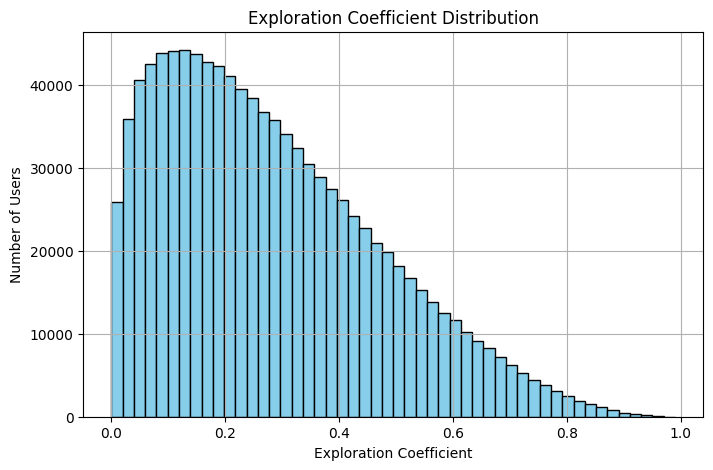

In [8]:
# 📊 Show exploration coefficient statistics
print("\n📈 Exploration Coefficient Statistics:")
print(f"Min: {exploration_coeffs.min():.4f}")
print(f"P1: {np.percentile(exploration_coeffs, 1):.4f}")
print(f"P25: {np.percentile(exploration_coeffs, 25):.4f}")
print(f"Median: {np.median(exploration_coeffs):.4f}")
print(f"Mean: {np.mean(exploration_coeffs):.4f}")
print(f"P75: {np.percentile(exploration_coeffs, 75):.4f}")
print(f"P99: {np.percentile(exploration_coeffs, 99):.4f}")
print(f"Max: {exploration_coeffs.max():.4f}")

# 📈 Plot exploration coefficient distribution
plt.figure(figsize=(8, 5))
plt.hist(exploration_coeffs, bins=50, color='skyblue', edgecolor='black')
plt.title("Exploration Coefficient Distribution")
plt.xlabel("Exploration Coefficient")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()

In [9]:
# Explore parquet files that have user, playlist, and number of song matches between both

import pandas as pd
import os


# 📂 Path to your input directory
input_dir = "/content/drive/My Drive/datasets/overlap_processed"

# 📄 List available parquet files
parquet_files = sorted(f for f in os.listdir(input_dir) if f.endswith(".parquet"))
print(f"Found {len(parquet_files)} files. Example file: {parquet_files[0]}")

# 📥 Load one file
sample_file = os.path.join(input_dir, parquet_files[0])
df = pd.read_parquet(sample_file)

# 🔍 Show column names
print("\n📋 Columns in sample parquet slice:")
print(df.columns.tolist())

# 🔍 Show a few rows
print("\n🔎 First few rows:")
print(df.head())

Found 102 files. Example file: overlap_0_10000.parquet

📋 Columns in sample parquet slice:
['user_id', 'playlist_id', 'song_count']

🔎 First few rows:
   user_id  playlist_id  song_count
0        0       910083           1
1        0       881762           1
2        0       640163           1
3        0       579309           1
4        0       568368           1


In [1]:
import os
import pickle
import polars as pl
from tqdm import tqdm

# === Paths ===
input_dir = "/content/drive/My Drive/datasets/overlap_processed"  # Overlap slices
output_dir = "/content/drive/My Drive/datasets/userplaylist_score_slices"  # Scored slices
os.makedirs(output_dir, exist_ok=True)

# === Load mappings ===
idx_to_user_df = pl.read_parquet("/content/drive/My Drive/datasets/idx_to_user.parquet")
idx_to_playlist_df = pl.read_parquet("/content/drive/My Drive/datasets/idx_to_playlist.parquet")

idx_to_playlist = dict(zip(idx_to_playlist_df["playlist_idx"].to_numpy(), idx_to_playlist_df["playlist_id"].to_numpy()))

# Load user and playlist song counts
user_song_counts = pl.read_parquet("/content/drive/My Drive/datasets/user_song_counts_idx.parquet")
playlist_song_counts = pl.read_parquet("/content/drive/My Drive/datasets/playlist_song_counts_idx.parquet")

user_song_map = dict(zip(user_song_counts["user_idx"].to_numpy(), user_song_counts["song_count"].to_numpy()))
playlist_song_map = dict(zip(playlist_song_counts["playlist_idx"].to_numpy(), playlist_song_counts["song_count"].to_numpy()))

# Load exploration coefficients
with open("/content/drive/My Drive/datasets/exploration_map.pkl", "rb") as f:
    exploration_map = pickle.load(f)

# === Start processing slices ===
parquet_files = sorted(f for f in os.listdir(input_dir) if f.endswith(".parquet"))

for file_name in tqdm(parquet_files, desc="🧮 Processing slices (Polars Version)"):
    path = os.path.join(input_dir, file_name)

    # Read the slice
    df = pl.read_parquet(path)

    # Rename column
    df = df.rename({"song_count": "match_count"})

    # Filter match_count > 0
    df = df.filter(pl.col("match_count") > 0)

    # Assume user_id is already user_idx
    df = df.with_columns([
        pl.col("user_id").alias("user_idx"),
        pl.col("playlist_id").alias("playlist_idx")
    ])

    # Map playlist_id → real_playlist_id, and add user/song counts and exploration coefficient
    # Create mapping DataFrames
    idx_to_playlist_df = pl.DataFrame({
        "playlist_idx": list(idx_to_playlist.keys()),
        "real_playlist_id": list(idx_to_playlist.values())
    })

    user_song_map_df = pl.DataFrame({
        "user_idx": list(user_song_map.keys()),
        "s": list(user_song_map.values())
    })

    playlist_song_map_df = pl.DataFrame({
        "playlist_idx": list(playlist_song_map.keys()),
        "p": list(playlist_song_map.values())
    })

    exploration_map_df = pl.DataFrame({
        "user_idx": list(exploration_map.keys()),
        "e": list(exploration_map.values())
    })

    # Merge metadata via fast joins
    df = df.join(idx_to_playlist_df, on="playlist_idx", how="left")
    df = df.join(user_song_map_df, on="user_idx", how="left")
    df = df.join(playlist_song_map_df, on="playlist_idx", how="left")
    df = df.join(exploration_map_df, on="user_idx", how="left")

    # Drop missing mappings
    df = df.drop_nulls(subset=["real_playlist_id", "s", "p", "e"])

    # Compute score
    df = df.with_columns([
        (
            ((1 - pl.col("e")) * (pl.col("match_count") + 1).log() + pl.col("e"))
            / (pl.col("s").sqrt() * pl.col("p").sqrt())
        ).alias("score")
    ])

    # Print some stats
    print(f"✅ Median score of {file_name}: {df['score'].median():.4f}")
    print(f"✅ Min score of {file_name}: {df['score'].min():.4f}")
    print(f"✅ Max score of {file_name}: {df['score'].max():.4f}")

    # Save only the needed columns
    output_path = os.path.join(output_dir, f"scored_{file_name}")
    df.select(["user_idx", "playlist_idx", "match_count", "score"]).write_parquet(output_path)

print("\n✅✅ All slices processed and scores saved to:", output_dir)

🧮 Processing slices (Polars Version):   0%|          | 0/102 [00:00<?, ?it/s]

✅ Median score of overlap_0_10000.parquet: 0.0125
✅ Min score of overlap_0_10000.parquet: 0.0012
✅ Max score of overlap_0_10000.parquet: 0.4773


🧮 Processing slices (Polars Version):   1%|          | 1/102 [01:50<3:06:23, 110.73s/it]

✅ Median score of overlap_1000000_1010000.parquet: 0.0170
✅ Min score of overlap_1000000_1010000.parquet: 0.0012
✅ Max score of overlap_1000000_1010000.parquet: 0.3880


🧮 Processing slices (Polars Version):   2%|▏         | 2/102 [03:57<3:19:59, 119.99s/it]

✅ Median score of overlap_100000_110000.parquet: 0.0173
✅ Min score of overlap_100000_110000.parquet: 0.0013
✅ Max score of overlap_100000_110000.parquet: 0.3900


🧮 Processing slices (Polars Version):   3%|▎         | 3/102 [05:24<2:53:43, 105.28s/it]

✅ Median score of overlap_10000_20000.parquet: 0.0170
✅ Min score of overlap_10000_20000.parquet: 0.0012
✅ Max score of overlap_10000_20000.parquet: 0.4227


🧮 Processing slices (Polars Version):   4%|▍         | 4/102 [06:49<2:38:29, 97.04s/it] 

✅ Median score of overlap_1010000_1019318.parquet: 0.0171
✅ Min score of overlap_1010000_1019318.parquet: 0.0013
✅ Max score of overlap_1010000_1019318.parquet: 0.4051


🧮 Processing slices (Polars Version):   5%|▍         | 5/102 [08:22<2:34:35, 95.63s/it]

✅ Median score of overlap_110000_120000.parquet: 0.0172
✅ Min score of overlap_110000_120000.parquet: 0.0012
✅ Max score of overlap_110000_120000.parquet: 0.4238


🧮 Processing slices (Polars Version):   6%|▌         | 6/102 [09:43<2:25:05, 90.68s/it]

✅ Median score of overlap_120000_130000.parquet: 0.0171
✅ Min score of overlap_120000_130000.parquet: 0.0012
✅ Max score of overlap_120000_130000.parquet: 0.3993


🧮 Processing slices (Polars Version):   7%|▋         | 7/102 [11:13<2:23:05, 90.38s/it]

✅ Median score of overlap_130000_140000.parquet: 0.0171
✅ Min score of overlap_130000_140000.parquet: 0.0012
✅ Max score of overlap_130000_140000.parquet: 0.3907


🧮 Processing slices (Polars Version):   8%|▊         | 8/102 [12:39<2:19:27, 89.02s/it]

✅ Median score of overlap_140000_150000.parquet: 0.0170
✅ Min score of overlap_140000_150000.parquet: 0.0012
✅ Max score of overlap_140000_150000.parquet: 0.3675


🧮 Processing slices (Polars Version):   9%|▉         | 9/102 [14:13<2:20:22, 90.57s/it]

✅ Median score of overlap_150000_160000.parquet: 0.0170
✅ Min score of overlap_150000_160000.parquet: 0.0012
✅ Max score of overlap_150000_160000.parquet: 0.3779


🧮 Processing slices (Polars Version):  10%|▉         | 10/102 [15:37<2:15:39, 88.47s/it]

✅ Median score of overlap_160000_170000.parquet: 0.0171
✅ Min score of overlap_160000_170000.parquet: 0.0012
✅ Max score of overlap_160000_170000.parquet: 0.3769


🧮 Processing slices (Polars Version):  11%|█         | 11/102 [16:54<2:09:03, 85.10s/it]

✅ Median score of overlap_170000_180000.parquet: 0.0171
✅ Min score of overlap_170000_180000.parquet: 0.0012
✅ Max score of overlap_170000_180000.parquet: 0.4610


🧮 Processing slices (Polars Version):  12%|█▏        | 12/102 [18:21<2:08:27, 85.64s/it]

✅ Median score of overlap_180000_190000.parquet: 0.0171
✅ Min score of overlap_180000_190000.parquet: 0.0012
✅ Max score of overlap_180000_190000.parquet: 0.3812


🧮 Processing slices (Polars Version):  13%|█▎        | 13/102 [19:43<2:05:30, 84.61s/it]

✅ Median score of overlap_190000_200000.parquet: 0.0169
✅ Min score of overlap_190000_200000.parquet: 0.0012
✅ Max score of overlap_190000_200000.parquet: 0.3944


🧮 Processing slices (Polars Version):  14%|█▎        | 14/102 [21:02<2:01:33, 82.88s/it]

✅ Median score of overlap_200000_210000.parquet: 0.0171
✅ Min score of overlap_200000_210000.parquet: 0.0012
✅ Max score of overlap_200000_210000.parquet: 0.3907


🧮 Processing slices (Polars Version):  15%|█▍        | 15/102 [23:11<2:20:26, 96.85s/it]

✅ Median score of overlap_20000_30000.parquet: 0.0171
✅ Min score of overlap_20000_30000.parquet: 0.0013
✅ Max score of overlap_20000_30000.parquet: 0.3825


🧮 Processing slices (Polars Version):  16%|█▌        | 16/102 [24:32<2:11:39, 91.86s/it]

✅ Median score of overlap_210000_220000.parquet: 0.0172
✅ Min score of overlap_210000_220000.parquet: 0.0012
✅ Max score of overlap_210000_220000.parquet: 0.3884


🧮 Processing slices (Polars Version):  17%|█▋        | 17/102 [25:56<2:07:08, 89.74s/it]

✅ Median score of overlap_220000_230000.parquet: 0.0172
✅ Min score of overlap_220000_230000.parquet: 0.0012
✅ Max score of overlap_220000_230000.parquet: 0.3991


🧮 Processing slices (Polars Version):  18%|█▊        | 18/102 [27:19<2:02:25, 87.44s/it]

✅ Median score of overlap_230000_240000.parquet: 0.0171
✅ Min score of overlap_230000_240000.parquet: 0.0012
✅ Max score of overlap_230000_240000.parquet: 0.3820


🧮 Processing slices (Polars Version):  19%|█▊        | 19/102 [28:40<1:58:35, 85.73s/it]

✅ Median score of overlap_240000_250000.parquet: 0.0171
✅ Min score of overlap_240000_250000.parquet: 0.0013
✅ Max score of overlap_240000_250000.parquet: 0.5368


🧮 Processing slices (Polars Version):  20%|█▉        | 20/102 [29:58<1:53:43, 83.21s/it]

✅ Median score of overlap_250000_260000.parquet: 0.0169
✅ Min score of overlap_250000_260000.parquet: 0.0012
✅ Max score of overlap_250000_260000.parquet: 0.3866


🧮 Processing slices (Polars Version):  21%|██        | 21/102 [31:17<1:50:57, 82.19s/it]

✅ Median score of overlap_260000_270000.parquet: 0.0172
✅ Min score of overlap_260000_270000.parquet: 0.0012
✅ Max score of overlap_260000_270000.parquet: 0.4398


🧮 Processing slices (Polars Version):  22%|██▏       | 22/102 [32:59<1:57:20, 88.00s/it]

✅ Median score of overlap_270000_280000.parquet: 0.0171
✅ Min score of overlap_270000_280000.parquet: 0.0012
✅ Max score of overlap_270000_280000.parquet: 0.4720


🧮 Processing slices (Polars Version):  23%|██▎       | 23/102 [34:23<1:54:09, 86.70s/it]

✅ Median score of overlap_280000_290000.parquet: 0.0170
✅ Min score of overlap_280000_290000.parquet: 0.0012
✅ Max score of overlap_280000_290000.parquet: 0.3906


🧮 Processing slices (Polars Version):  24%|██▎       | 24/102 [35:44<1:50:47, 85.22s/it]

✅ Median score of overlap_290000_300000.parquet: 0.0170
✅ Min score of overlap_290000_300000.parquet: 0.0012
✅ Max score of overlap_290000_300000.parquet: 0.3793


🧮 Processing slices (Polars Version):  25%|██▍       | 25/102 [37:04<1:47:15, 83.58s/it]

✅ Median score of overlap_300000_310000.parquet: 0.0172
✅ Min score of overlap_300000_310000.parquet: 0.0012
✅ Max score of overlap_300000_310000.parquet: 0.3944


🧮 Processing slices (Polars Version):  25%|██▌       | 26/102 [38:31<1:47:01, 84.49s/it]

✅ Median score of overlap_30000_40000.parquet: 0.0171
✅ Min score of overlap_30000_40000.parquet: 0.0012
✅ Max score of overlap_30000_40000.parquet: 0.3906


🧮 Processing slices (Polars Version):  26%|██▋       | 27/102 [39:52<1:44:23, 83.52s/it]

✅ Median score of overlap_310000_320000.parquet: 0.0171
✅ Min score of overlap_310000_320000.parquet: 0.0012
✅ Max score of overlap_310000_320000.parquet: 0.3987


🧮 Processing slices (Polars Version):  27%|██▋       | 28/102 [41:30<1:48:25, 87.91s/it]

✅ Median score of overlap_320000_330000.parquet: 0.0171
✅ Min score of overlap_320000_330000.parquet: 0.0012
✅ Max score of overlap_320000_330000.parquet: 0.4695


🧮 Processing slices (Polars Version):  28%|██▊       | 29/102 [42:49<1:43:34, 85.12s/it]

✅ Median score of overlap_330000_340000.parquet: 0.0169
✅ Min score of overlap_330000_340000.parquet: 0.0012
✅ Max score of overlap_330000_340000.parquet: 0.4850


🧮 Processing slices (Polars Version):  29%|██▉       | 30/102 [44:31<1:48:20, 90.29s/it]

✅ Median score of overlap_340000_350000.parquet: 0.0171
✅ Min score of overlap_340000_350000.parquet: 0.0012
✅ Max score of overlap_340000_350000.parquet: 0.4079


🧮 Processing slices (Polars Version):  30%|███       | 31/102 [45:56<1:44:58, 88.71s/it]

✅ Median score of overlap_350000_360000.parquet: 0.0172
✅ Min score of overlap_350000_360000.parquet: 0.0012
✅ Max score of overlap_350000_360000.parquet: 0.3913


🧮 Processing slices (Polars Version):  31%|███▏      | 32/102 [47:10<1:38:08, 84.12s/it]

✅ Median score of overlap_360000_370000.parquet: 0.0172
✅ Min score of overlap_360000_370000.parquet: 0.0012
✅ Max score of overlap_360000_370000.parquet: 0.4976


🧮 Processing slices (Polars Version):  32%|███▏      | 33/102 [48:35<1:37:17, 84.60s/it]

✅ Median score of overlap_370000_380000.parquet: 0.0170
✅ Min score of overlap_370000_380000.parquet: 0.0013
✅ Max score of overlap_370000_380000.parquet: 0.3952


🧮 Processing slices (Polars Version):  33%|███▎      | 34/102 [49:54<1:33:49, 82.78s/it]

✅ Median score of overlap_380000_390000.parquet: 0.0173
✅ Min score of overlap_380000_390000.parquet: 0.0012
✅ Max score of overlap_380000_390000.parquet: 0.3712


🧮 Processing slices (Polars Version):  34%|███▍      | 35/102 [51:18<1:32:50, 83.14s/it]

✅ Median score of overlap_390000_400000.parquet: 0.0171
✅ Min score of overlap_390000_400000.parquet: 0.0012
✅ Max score of overlap_390000_400000.parquet: 0.3785


🧮 Processing slices (Polars Version):  35%|███▌      | 36/102 [52:41<1:31:19, 83.03s/it]

✅ Median score of overlap_400000_410000.parquet: 0.0171
✅ Min score of overlap_400000_410000.parquet: 0.0012
✅ Max score of overlap_400000_410000.parquet: 0.3987


🧮 Processing slices (Polars Version):  36%|███▋      | 37/102 [54:21<1:35:34, 88.22s/it]

✅ Median score of overlap_40000_50000.parquet: 0.0172
✅ Min score of overlap_40000_50000.parquet: 0.0013
✅ Max score of overlap_40000_50000.parquet: 0.3952


🧮 Processing slices (Polars Version):  37%|███▋      | 38/102 [55:51<1:34:33, 88.65s/it]

✅ Median score of overlap_410000_420000.parquet: 0.0171
✅ Min score of overlap_410000_420000.parquet: 0.0013
✅ Max score of overlap_410000_420000.parquet: 0.5143


🧮 Processing slices (Polars Version):  38%|███▊      | 39/102 [57:10<1:30:09, 85.87s/it]

✅ Median score of overlap_420000_430000.parquet: 0.0171
✅ Min score of overlap_420000_430000.parquet: 0.0012
✅ Max score of overlap_420000_430000.parquet: 0.3859


🧮 Processing slices (Polars Version):  39%|███▉      | 40/102 [58:32<1:27:33, 84.74s/it]

✅ Median score of overlap_430000_440000.parquet: 0.0171
✅ Min score of overlap_430000_440000.parquet: 0.0013
✅ Max score of overlap_430000_440000.parquet: 0.4025


🧮 Processing slices (Polars Version):  40%|████      | 41/102 [59:55<1:25:34, 84.17s/it]

✅ Median score of overlap_440000_450000.parquet: 0.0170
✅ Min score of overlap_440000_450000.parquet: 0.0014
✅ Max score of overlap_440000_450000.parquet: 0.4447


🧮 Processing slices (Polars Version):  41%|████      | 42/102 [1:01:29<1:27:09, 87.16s/it]

✅ Median score of overlap_450000_460000.parquet: 0.0171
✅ Min score of overlap_450000_460000.parquet: 0.0012
✅ Max score of overlap_450000_460000.parquet: 0.4617


🧮 Processing slices (Polars Version):  42%|████▏     | 43/102 [1:02:54<1:25:05, 86.53s/it]

✅ Median score of overlap_460000_470000.parquet: 0.0171
✅ Min score of overlap_460000_470000.parquet: 0.0012
✅ Max score of overlap_460000_470000.parquet: 0.3915


🧮 Processing slices (Polars Version):  43%|████▎     | 44/102 [1:04:37<1:28:27, 91.51s/it]

✅ Median score of overlap_470000_480000.parquet: 0.0171
✅ Min score of overlap_470000_480000.parquet: 0.0013
✅ Max score of overlap_470000_480000.parquet: 0.3497


🧮 Processing slices (Polars Version):  44%|████▍     | 45/102 [1:05:58<1:23:51, 88.28s/it]

✅ Median score of overlap_480000_490000.parquet: 0.0172
✅ Min score of overlap_480000_490000.parquet: 0.0012
✅ Max score of overlap_480000_490000.parquet: 0.3630


🧮 Processing slices (Polars Version):  45%|████▌     | 46/102 [1:07:13<1:18:40, 84.29s/it]

✅ Median score of overlap_490000_500000.parquet: 0.0171
✅ Min score of overlap_490000_500000.parquet: 0.0012
✅ Max score of overlap_490000_500000.parquet: 0.3868


🧮 Processing slices (Polars Version):  46%|████▌     | 47/102 [1:08:41<1:18:24, 85.53s/it]

✅ Median score of overlap_500000_510000.parquet: 0.0169
✅ Min score of overlap_500000_510000.parquet: 0.0012
✅ Max score of overlap_500000_510000.parquet: 0.4020


🧮 Processing slices (Polars Version):  47%|████▋     | 48/102 [1:10:20<1:20:25, 89.35s/it]

✅ Median score of overlap_50000_60000.parquet: 0.0170
✅ Min score of overlap_50000_60000.parquet: 0.0012
✅ Max score of overlap_50000_60000.parquet: 0.5014


🧮 Processing slices (Polars Version):  48%|████▊     | 49/102 [1:11:40<1:16:31, 86.64s/it]

✅ Median score of overlap_510000_520000.parquet: 0.0173
✅ Min score of overlap_510000_520000.parquet: 0.0012
✅ Max score of overlap_510000_520000.parquet: 0.4377


🧮 Processing slices (Polars Version):  49%|████▉     | 50/102 [1:13:11<1:16:10, 87.89s/it]

✅ Median score of overlap_520000_530000.parquet: 0.0171
✅ Min score of overlap_520000_530000.parquet: 0.0012
✅ Max score of overlap_520000_530000.parquet: 0.4666


🧮 Processing slices (Polars Version):  50%|█████     | 51/102 [1:14:37<1:14:12, 87.31s/it]

✅ Median score of overlap_530000_540000.parquet: 0.0171
✅ Min score of overlap_530000_540000.parquet: 0.0012
✅ Max score of overlap_530000_540000.parquet: 0.4199


🧮 Processing slices (Polars Version):  51%|█████     | 52/102 [1:16:08<1:13:48, 88.56s/it]

✅ Median score of overlap_540000_550000.parquet: 0.0171
✅ Min score of overlap_540000_550000.parquet: 0.0012
✅ Max score of overlap_540000_550000.parquet: 0.4172


🧮 Processing slices (Polars Version):  52%|█████▏    | 53/102 [1:17:33<1:11:25, 87.45s/it]

✅ Median score of overlap_550000_560000.parquet: 0.0171
✅ Min score of overlap_550000_560000.parquet: 0.0012
✅ Max score of overlap_550000_560000.parquet: 0.4922


🧮 Processing slices (Polars Version):  53%|█████▎    | 54/102 [1:19:00<1:09:48, 87.25s/it]

✅ Median score of overlap_560000_570000.parquet: 0.0171
✅ Min score of overlap_560000_570000.parquet: 0.0012
✅ Max score of overlap_560000_570000.parquet: 0.5097


🧮 Processing slices (Polars Version):  54%|█████▍    | 55/102 [1:20:27<1:08:19, 87.22s/it]

✅ Median score of overlap_570000_580000.parquet: 0.0172
✅ Min score of overlap_570000_580000.parquet: 0.0012
✅ Max score of overlap_570000_580000.parquet: 0.3910


🧮 Processing slices (Polars Version):  55%|█████▍    | 56/102 [1:21:49<1:05:45, 85.77s/it]

✅ Median score of overlap_580000_590000.parquet: 0.0169
✅ Min score of overlap_580000_590000.parquet: 0.0012
✅ Max score of overlap_580000_590000.parquet: 0.3916


🧮 Processing slices (Polars Version):  56%|█████▌    | 57/102 [1:23:12<1:03:33, 84.74s/it]

✅ Median score of overlap_590000_600000.parquet: 0.0170
✅ Min score of overlap_590000_600000.parquet: 0.0012
✅ Max score of overlap_590000_600000.parquet: 0.3826


🧮 Processing slices (Polars Version):  57%|█████▋    | 58/102 [1:24:34<1:01:32, 83.91s/it]

✅ Median score of overlap_600000_610000.parquet: 0.0173
✅ Min score of overlap_600000_610000.parquet: 0.0012
✅ Max score of overlap_600000_610000.parquet: 0.5040


🧮 Processing slices (Polars Version):  58%|█████▊    | 59/102 [1:26:38<1:08:48, 96.02s/it]

✅ Median score of overlap_60000_70000.parquet: 0.0171
✅ Min score of overlap_60000_70000.parquet: 0.0012
✅ Max score of overlap_60000_70000.parquet: 0.3979


🧮 Processing slices (Polars Version):  59%|█████▉    | 60/102 [1:28:04<1:05:11, 93.13s/it]

✅ Median score of overlap_610000_620000.parquet: 0.0173
✅ Min score of overlap_610000_620000.parquet: 0.0012
✅ Max score of overlap_610000_620000.parquet: 0.3878


🧮 Processing slices (Polars Version):  60%|█████▉    | 61/102 [1:29:31<1:02:18, 91.17s/it]

✅ Median score of overlap_620000_630000.parquet: 0.0169
✅ Min score of overlap_620000_630000.parquet: 0.0012
✅ Max score of overlap_620000_630000.parquet: 0.4923


🧮 Processing slices (Polars Version):  61%|██████    | 62/102 [1:30:53<58:58, 88.46s/it]  

✅ Median score of overlap_630000_640000.parquet: 0.0171
✅ Min score of overlap_630000_640000.parquet: 0.0012
✅ Max score of overlap_630000_640000.parquet: 0.4265


🧮 Processing slices (Polars Version):  62%|██████▏   | 63/102 [1:32:12<55:35, 85.53s/it]

✅ Median score of overlap_640000_650000.parquet: 0.0174
✅ Min score of overlap_640000_650000.parquet: 0.0013
✅ Max score of overlap_640000_650000.parquet: 0.4542


🧮 Processing slices (Polars Version):  63%|██████▎   | 64/102 [1:33:53<57:04, 90.12s/it]

✅ Median score of overlap_650000_660000.parquet: 0.0171
✅ Min score of overlap_650000_660000.parquet: 0.0012
✅ Max score of overlap_650000_660000.parquet: 0.5407


🧮 Processing slices (Polars Version):  64%|██████▎   | 65/102 [1:35:16<54:17, 88.04s/it]

✅ Median score of overlap_660000_670000.parquet: 0.0173
✅ Min score of overlap_660000_670000.parquet: 0.0012
✅ Max score of overlap_660000_670000.parquet: 0.3708


🧮 Processing slices (Polars Version):  65%|██████▍   | 66/102 [1:36:53<54:26, 90.74s/it]

✅ Median score of overlap_670000_680000.parquet: 0.0170
✅ Min score of overlap_670000_680000.parquet: 0.0012
✅ Max score of overlap_670000_680000.parquet: 0.3761


🧮 Processing slices (Polars Version):  66%|██████▌   | 67/102 [1:38:14<51:19, 87.99s/it]

✅ Median score of overlap_680000_690000.parquet: 0.0171
✅ Min score of overlap_680000_690000.parquet: 0.0012
✅ Max score of overlap_680000_690000.parquet: 0.3824


🧮 Processing slices (Polars Version):  67%|██████▋   | 68/102 [1:39:37<48:53, 86.28s/it]

✅ Median score of overlap_690000_700000.parquet: 0.0170
✅ Min score of overlap_690000_700000.parquet: 0.0013
✅ Max score of overlap_690000_700000.parquet: 0.3796


🧮 Processing slices (Polars Version):  68%|██████▊   | 69/102 [1:41:00<46:54, 85.28s/it]

✅ Median score of overlap_700000_710000.parquet: 0.0172
✅ Min score of overlap_700000_710000.parquet: 0.0013
✅ Max score of overlap_700000_710000.parquet: 0.4935


🧮 Processing slices (Polars Version):  69%|██████▊   | 70/102 [1:42:21<44:53, 84.19s/it]

✅ Median score of overlap_70000_80000.parquet: 0.0170
✅ Min score of overlap_70000_80000.parquet: 0.0012
✅ Max score of overlap_70000_80000.parquet: 0.4753


🧮 Processing slices (Polars Version):  70%|██████▉   | 71/102 [1:43:41<42:50, 82.91s/it]

✅ Median score of overlap_710000_720000.parquet: 0.0171
✅ Min score of overlap_710000_720000.parquet: 0.0013
✅ Max score of overlap_710000_720000.parquet: 0.3916


🧮 Processing slices (Polars Version):  71%|███████   | 72/102 [1:45:02<41:10, 82.34s/it]

✅ Median score of overlap_720000_730000.parquet: 0.0172
✅ Min score of overlap_720000_730000.parquet: 0.0013
✅ Max score of overlap_720000_730000.parquet: 0.4222


🧮 Processing slices (Polars Version):  72%|███████▏  | 73/102 [1:46:25<39:54, 82.58s/it]

✅ Median score of overlap_730000_740000.parquet: 0.0171
✅ Min score of overlap_730000_740000.parquet: 0.0012
✅ Max score of overlap_730000_740000.parquet: 0.3882


🧮 Processing slices (Polars Version):  73%|███████▎  | 74/102 [1:48:01<40:17, 86.35s/it]

✅ Median score of overlap_740000_750000.parquet: 0.0172
✅ Min score of overlap_740000_750000.parquet: 0.0012
✅ Max score of overlap_740000_750000.parquet: 0.3973


🧮 Processing slices (Polars Version):  74%|███████▎  | 75/102 [1:49:21<38:02, 84.54s/it]

✅ Median score of overlap_750000_760000.parquet: 0.0172
✅ Min score of overlap_750000_760000.parquet: 0.0013
✅ Max score of overlap_750000_760000.parquet: 0.3903


🧮 Processing slices (Polars Version):  75%|███████▍  | 76/102 [1:50:53<37:33, 86.67s/it]

✅ Median score of overlap_760000_770000.parquet: 0.0172
✅ Min score of overlap_760000_770000.parquet: 0.0012
✅ Max score of overlap_760000_770000.parquet: 0.4432


🧮 Processing slices (Polars Version):  75%|███████▌  | 77/102 [1:52:13<35:17, 84.72s/it]

✅ Median score of overlap_770000_780000.parquet: 0.0170
✅ Min score of overlap_770000_780000.parquet: 0.0012
✅ Max score of overlap_770000_780000.parquet: 0.5199


🧮 Processing slices (Polars Version):  76%|███████▋  | 78/102 [1:53:31<33:09, 82.92s/it]

✅ Median score of overlap_780000_790000.parquet: 0.0170
✅ Min score of overlap_780000_790000.parquet: 0.0013
✅ Max score of overlap_780000_790000.parquet: 0.3899


🧮 Processing slices (Polars Version):  77%|███████▋  | 79/102 [1:55:01<32:34, 84.99s/it]

✅ Median score of overlap_790000_800000.parquet: 0.0170
✅ Min score of overlap_790000_800000.parquet: 0.0013
✅ Max score of overlap_790000_800000.parquet: 0.4656


🧮 Processing slices (Polars Version):  78%|███████▊  | 80/102 [1:56:20<30:25, 82.99s/it]

✅ Median score of overlap_800000_810000.parquet: 0.0171
✅ Min score of overlap_800000_810000.parquet: 0.0013
✅ Max score of overlap_800000_810000.parquet: 0.3813


🧮 Processing slices (Polars Version):  79%|███████▉  | 81/102 [1:58:10<31:53, 91.13s/it]

✅ Median score of overlap_80000_90000.parquet: 0.0172
✅ Min score of overlap_80000_90000.parquet: 0.0012
✅ Max score of overlap_80000_90000.parquet: 0.4265


🧮 Processing slices (Polars Version):  80%|████████  | 82/102 [1:59:30<29:15, 87.78s/it]

✅ Median score of overlap_810000_820000.parquet: 0.0171
✅ Min score of overlap_810000_820000.parquet: 0.0012
✅ Max score of overlap_810000_820000.parquet: 0.4671


🧮 Processing slices (Polars Version):  81%|████████▏ | 83/102 [2:01:01<28:06, 88.75s/it]

✅ Median score of overlap_820000_830000.parquet: 0.0172
✅ Min score of overlap_820000_830000.parquet: 0.0012
✅ Max score of overlap_820000_830000.parquet: 0.3913


🧮 Processing slices (Polars Version):  82%|████████▏ | 84/102 [2:02:46<28:06, 93.71s/it]

✅ Median score of overlap_830000_840000.parquet: 0.0171
✅ Min score of overlap_830000_840000.parquet: 0.0012
✅ Max score of overlap_830000_840000.parquet: 0.4079


🧮 Processing slices (Polars Version):  83%|████████▎ | 85/102 [2:04:08<25:34, 90.27s/it]

✅ Median score of overlap_840000_850000.parquet: 0.0171
✅ Min score of overlap_840000_850000.parquet: 0.0012
✅ Max score of overlap_840000_850000.parquet: 0.3917


🧮 Processing slices (Polars Version):  84%|████████▍ | 86/102 [2:05:30<23:22, 87.68s/it]

✅ Median score of overlap_850000_860000.parquet: 0.0173
✅ Min score of overlap_850000_860000.parquet: 0.0013
✅ Max score of overlap_850000_860000.parquet: 0.4490


🧮 Processing slices (Polars Version):  85%|████████▌ | 87/102 [2:06:53<21:36, 86.43s/it]

✅ Median score of overlap_860000_870000.parquet: 0.0169
✅ Min score of overlap_860000_870000.parquet: 0.0012
✅ Max score of overlap_860000_870000.parquet: 0.5541


🧮 Processing slices (Polars Version):  86%|████████▋ | 88/102 [2:08:37<21:20, 91.46s/it]

✅ Median score of overlap_870000_880000.parquet: 0.0170
✅ Min score of overlap_870000_880000.parquet: 0.0013
✅ Max score of overlap_870000_880000.parquet: 0.3900


🧮 Processing slices (Polars Version):  87%|████████▋ | 89/102 [2:09:53<18:49, 86.91s/it]

✅ Median score of overlap_880000_890000.parquet: 0.0171
✅ Min score of overlap_880000_890000.parquet: 0.0012
✅ Max score of overlap_880000_890000.parquet: 0.5667


🧮 Processing slices (Polars Version):  88%|████████▊ | 90/102 [2:11:10<16:49, 84.13s/it]

✅ Median score of overlap_890000_900000.parquet: 0.0170
✅ Min score of overlap_890000_900000.parquet: 0.0013
✅ Max score of overlap_890000_900000.parquet: 0.3925


🧮 Processing slices (Polars Version):  89%|████████▉ | 91/102 [2:12:38<15:35, 85.02s/it]

✅ Median score of overlap_900000_910000.parquet: 0.0171
✅ Min score of overlap_900000_910000.parquet: 0.0016
✅ Max score of overlap_900000_910000.parquet: 0.3918


🧮 Processing slices (Polars Version):  90%|█████████ | 92/102 [2:13:54<13:45, 82.51s/it]

✅ Median score of overlap_90000_100000.parquet: 0.0173
✅ Min score of overlap_90000_100000.parquet: 0.0012
✅ Max score of overlap_90000_100000.parquet: 0.3926


🧮 Processing slices (Polars Version):  91%|█████████ | 93/102 [2:15:16<12:20, 82.26s/it]

✅ Median score of overlap_910000_920000.parquet: 0.0172
✅ Min score of overlap_910000_920000.parquet: 0.0013
✅ Max score of overlap_910000_920000.parquet: 0.3933


🧮 Processing slices (Polars Version):  92%|█████████▏| 94/102 [2:16:33<10:45, 80.67s/it]

✅ Median score of overlap_920000_930000.parquet: 0.0171
✅ Min score of overlap_920000_930000.parquet: 0.0013
✅ Max score of overlap_920000_930000.parquet: 0.3922


🧮 Processing slices (Polars Version):  93%|█████████▎| 95/102 [2:17:50<09:18, 79.74s/it]

✅ Median score of overlap_930000_940000.parquet: 0.0170
✅ Min score of overlap_930000_940000.parquet: 0.0013
✅ Max score of overlap_930000_940000.parquet: 0.3913


🧮 Processing slices (Polars Version):  94%|█████████▍| 96/102 [2:19:44<09:00, 90.01s/it]

✅ Median score of overlap_940000_950000.parquet: 0.0170
✅ Min score of overlap_940000_950000.parquet: 0.0013
✅ Max score of overlap_940000_950000.parquet: 0.4567


🧮 Processing slices (Polars Version):  95%|█████████▌| 97/102 [2:21:06<07:17, 87.59s/it]

✅ Median score of overlap_950000_960000.parquet: 0.0171
✅ Min score of overlap_950000_960000.parquet: 0.0012
✅ Max score of overlap_950000_960000.parquet: 0.3903


🧮 Processing slices (Polars Version):  96%|█████████▌| 98/102 [2:22:25<05:39, 84.89s/it]

✅ Median score of overlap_960000_970000.parquet: 0.0171
✅ Min score of overlap_960000_970000.parquet: 0.0013
✅ Max score of overlap_960000_970000.parquet: 0.3975


🧮 Processing slices (Polars Version):  97%|█████████▋| 99/102 [2:23:45<04:10, 83.35s/it]

✅ Median score of overlap_970000_980000.parquet: 0.0170
✅ Min score of overlap_970000_980000.parquet: 0.0012
✅ Max score of overlap_970000_980000.parquet: 0.5135


🧮 Processing slices (Polars Version):  98%|█████████▊| 100/102 [2:25:08<02:46, 83.29s/it]

✅ Median score of overlap_980000_990000.parquet: 0.0170
✅ Min score of overlap_980000_990000.parquet: 0.0013
✅ Max score of overlap_980000_990000.parquet: 0.3688


🧮 Processing slices (Polars Version):  99%|█████████▉| 101/102 [2:26:26<01:21, 81.69s/it]

✅ Median score of overlap_990000_1000000.parquet: 0.0172
✅ Min score of overlap_990000_1000000.parquet: 0.0013
✅ Max score of overlap_990000_1000000.parquet: 0.4191


🧮 Processing slices (Polars Version): 100%|██████████| 102/102 [2:28:08<00:00, 87.14s/it]


✅✅ All slices processed and scores saved to: /content/drive/My Drive/datasets/userplaylist_score_slices


### Part 6: Now that we have scores for each user-playlist combination, we will rank them

For this, we will take the 3% higher scores for each user and label them as '1'. Meaning that the user, given this playlist as a recommendation, would like the playlist (these are our true labels).

✅ Loaded scored_overlap_0_10000.parquet: 223192860 rows, 4 columns
✅ Labeled slice shape: (223192860, 4)

📊 Statistics for Slice:
Total users: 9984
Total rows: 223192860
Positive (liked) playlists: 6700735 (3.00%)
Negative (non-liked) playlists: 216492125 (97.00%)
Average playlists liked per user: 671.15
Median playlists liked per user: 397.00
Min playlists liked per user: 1.00
Max playlists liked per user: 8677.00


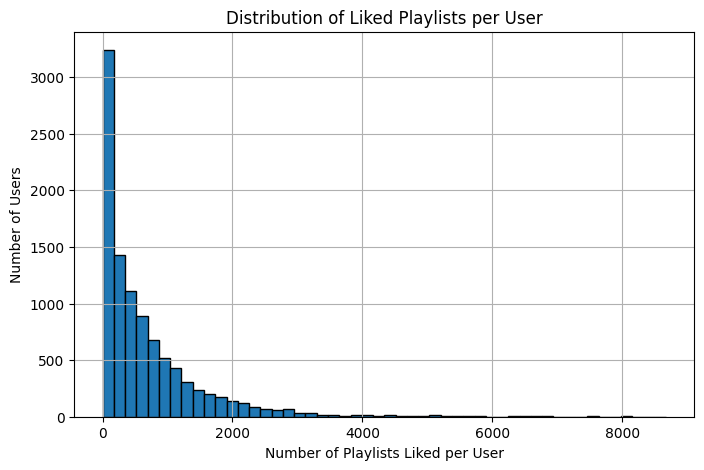


✅ Labeled slice saved to: /content/drive/My Drive/datasets/userplaylist_labeled_slices/labeled_scored_overlap_0_10000.parquet


In [1]:
# First let's test our labelling algorithm with one slice of data

import polars as pl
import matplotlib.pyplot as plt
import os

# === Configuration ===
K_PERCENT = 0.03  # Top K% playlists are considered "liked"

# === Paths ===
input_dir = "/content/drive/My Drive/datasets/userplaylist_score_slices"
output_dir = "/content/drive/My Drive/datasets/userplaylist_labeled_slices"
os.makedirs(output_dir, exist_ok=True)

# === Select one slice to test ===
file_name = "scored_overlap_0_10000.parquet"  # Change if needed
path = os.path.join(input_dir, file_name)

# === Load scored slice ===
df = pl.read_parquet(path)

print(f"✅ Loaded {file_name}: {df.shape[0]} rows, {df.shape[1]} columns")

# === Step 2: Rank and Label ===

# Sort playlists by user_idx and descending score
df = df.sort(["user_idx", "score"], descending=[False, True])

# Group by user_idx and assign ranks (0,1,2,...)
df = df.group_by("user_idx", maintain_order=True).agg([
    pl.col("playlist_idx"),
    pl.col("score"),
    pl.arange(0, pl.len()).alias("rank")
]).explode(["playlist_idx", "score", "rank"])

# Calculate number of playlists per user
user_counts = df.group_by("user_idx").agg([
    pl.len().alias("total_playlists")
])

# Join total playlists into main df
df = df.join(user_counts, on="user_idx", how="left")

# Calculate top_k per user: ceil(total_playlists * K_PERCENT), with minimum 1
df = df.with_columns([
    pl.when((pl.col("total_playlists") * K_PERCENT).ceil() < 1)
      .then(1)
      .otherwise((pl.col("total_playlists") * K_PERCENT).ceil())
      .alias("top_k")
])

# Label playlists: 1 if rank < top_k, else 0
df = df.with_columns([
    (pl.col("rank") < pl.col("top_k")).cast(pl.Int8).alias("label")
])

# Select final columns
df_labeled = df.select(["user_idx", "playlist_idx", "score", "label"])

print(f"✅ Labeled slice shape: {df_labeled.shape}")

# === Statistics ===
num_users = df_labeled["user_idx"].n_unique()
num_positives = df_labeled.filter(pl.col("label") == 1).shape[0]
num_negatives = df_labeled.filter(pl.col("label") == 0).shape[0]
total_rows = df_labeled.shape[0]

print("\n📊 Statistics for Slice:")
print(f"Total users: {num_users}")
print(f"Total rows: {total_rows}")
print(f"Positive (liked) playlists: {num_positives} ({num_positives / total_rows:.2%})")
print(f"Negative (non-liked) playlists: {num_negatives} ({num_negatives / total_rows:.2%})")

# Average liked playlists per user
liked_per_user = df_labeled.filter(pl.col("label") == 1).group_by("user_idx").len()
avg_likes_per_user = liked_per_user["len"].mean()
median_likes_per_user = liked_per_user["len"].median()
min_likes_per_user = liked_per_user["len"].min()
max_likes_per_user = liked_per_user["len"].max()
print(f"Average playlists liked per user: {avg_likes_per_user:.2f}")
print(f"Median playlists liked per user: {median_likes_per_user:.2f}")
print(f"Min playlists liked per user: {min_likes_per_user:.2f}")
print(f"Max playlists liked per user: {max_likes_per_user:.2f}")

# === Plot distribution: number of playlists each user liked
plt.figure(figsize=(8, 5))
plt.hist(liked_per_user["len"].to_numpy(), bins=50, edgecolor='black')
plt.xlabel("Number of Playlists Liked per User")
plt.ylabel("Number of Users")
plt.title("Distribution of Liked Playlists per User")
plt.grid(True)
plt.show()

# === Save labeled slice
output_path = os.path.join(output_dir, f"labeled_{file_name}")
df_labeled.write_parquet(output_path)

print(f"\n✅ Labeled slice saved to: {output_path}")


In [1]:
# Code for processing all slices

import polars as pl
import os
from tqdm import tqdm

# === Configuration ===
K_PERCENT = 0.03  # Top K% playlists considered "liked"
BATCH_SIZE = 3    # Number of slices to load into memory at once (depends on RAM)

# === Paths ===
input_dir = "/content/drive/My Drive/datasets/userplaylist_score_slices"
output_dir = "/content/drive/My Drive/datasets/userplaylist_labeled_slices"
os.makedirs(output_dir, exist_ok=True)

# === Find already processed files
input_files = sorted(f for f in os.listdir(input_dir) if f.endswith(".parquet"))
output_files = sorted(f for f in os.listdir(output_dir) if f.endswith(".parquet"))

processed_files = set(f.replace("labeled_", "").replace("scored_", "") for f in output_files)
remaining_files = [f for f in input_files if f.replace("scored_", "") not in processed_files]

if processed_files:
    print(f"🔁 Resuming: {len(processed_files)} files already completed, {len(remaining_files)} remaining.")
else:
    print(f"🚀 Starting fresh: {len(remaining_files)} files to process.")

# === Batch processing
for i in tqdm(range(0, len(remaining_files), BATCH_SIZE), desc="🧮 Processing batches"):
    batch_files = remaining_files[i:i+BATCH_SIZE]

    # Load all slices in batch
    batch_dfs = []
    for file_name in batch_files:
        path = os.path.join(input_dir, file_name)
        df = pl.read_parquet(path)
        df = df.sort(["user_idx", "score"], descending=[False, True])

        # Group by user_idx and assign rank
        df = df.group_by("user_idx", maintain_order=True).agg([
            pl.col("playlist_idx"),
            pl.col("score"),
            pl.arange(0, pl.len()).alias("rank")
        ]).explode(["playlist_idx", "score", "rank"])

        # Count playlists per user
        user_counts = df.group_by("user_idx").agg([
            pl.len().alias("total_playlists")
        ])

        # Join total playlists
        df = df.join(user_counts, on="user_idx", how="left")

        # Compute top_k
        df = df.with_columns([
            pl.when((pl.col("total_playlists") * K_PERCENT).ceil() < 1)
              .then(1)
              .otherwise((pl.col("total_playlists") * K_PERCENT).ceil())
              .alias("top_k")
        ])

        # Label playlists
        df = df.with_columns([
            (pl.col("rank") < pl.col("top_k")).cast(pl.Int8).alias("label")
        ])

        # Final selection
        df_labeled = df.select(["user_idx", "playlist_idx", "score", "label"])

        batch_dfs.append((file_name, df_labeled))

    # Save all labeled slices from batch
    for file_name, df_labeled in batch_dfs:
        output_file_name = "labeled_" + file_name
        output_path = os.path.join(output_dir, output_file_name)
        df_labeled.write_parquet(output_path)

    print(f"✅ Batch {i//BATCH_SIZE + 1}: Saved {len(batch_files)} labeled slices.")

print("\n✅✅ All slices processed and labeled saved to:", output_dir)

🚀 Starting fresh: 102 files to process.


🧮 Processing batches:   3%|▎         | 1/34 [03:36<1:58:52, 216.12s/it]

✅ Batch 1: Saved 3 labeled slices.


🧮 Processing batches:   6%|▌         | 2/34 [06:26<1:40:52, 189.15s/it]

✅ Batch 2: Saved 3 labeled slices.


🧮 Processing batches:   9%|▉         | 3/34 [09:14<1:32:49, 179.65s/it]

✅ Batch 3: Saved 3 labeled slices.


🧮 Processing batches:  12%|█▏        | 4/34 [12:29<1:32:52, 185.75s/it]

✅ Batch 4: Saved 3 labeled slices.


🧮 Processing batches:  15%|█▍        | 5/34 [15:30<1:28:55, 183.98s/it]

✅ Batch 5: Saved 3 labeled slices.


🧮 Processing batches:  18%|█▊        | 6/34 [18:33<1:25:41, 183.63s/it]

✅ Batch 6: Saved 3 labeled slices.


🧮 Processing batches:  21%|██        | 7/34 [21:26<1:21:02, 180.10s/it]

✅ Batch 7: Saved 3 labeled slices.


🧮 Processing batches:  24%|██▎       | 8/34 [24:53<1:21:46, 188.71s/it]

✅ Batch 8: Saved 3 labeled slices.


🧮 Processing batches:  26%|██▋       | 9/34 [28:16<1:20:28, 193.13s/it]

✅ Batch 9: Saved 3 labeled slices.


🧮 Processing batches:  29%|██▉       | 10/34 [31:19<1:15:56, 189.87s/it]

✅ Batch 10: Saved 3 labeled slices.


🧮 Processing batches:  32%|███▏      | 11/34 [34:50<1:15:17, 196.40s/it]

✅ Batch 11: Saved 3 labeled slices.


🧮 Processing batches:  35%|███▌      | 12/34 [37:48<1:10:00, 190.95s/it]

✅ Batch 12: Saved 3 labeled slices.


🧮 Processing batches:  38%|███▊      | 13/34 [40:43<1:05:09, 186.18s/it]

✅ Batch 13: Saved 3 labeled slices.


🧮 Processing batches:  41%|████      | 14/34 [43:56<1:02:40, 188.03s/it]

✅ Batch 14: Saved 3 labeled slices.


🧮 Processing batches:  44%|████▍     | 15/34 [46:57<58:51, 185.87s/it]  

✅ Batch 15: Saved 3 labeled slices.


🧮 Processing batches:  47%|████▋     | 16/34 [49:55<55:06, 183.71s/it]

✅ Batch 16: Saved 3 labeled slices.


🧮 Processing batches:  50%|█████     | 17/34 [52:58<51:58, 183.42s/it]

✅ Batch 17: Saved 3 labeled slices.


🧮 Processing batches:  53%|█████▎    | 18/34 [56:22<50:33, 189.60s/it]

✅ Batch 18: Saved 3 labeled slices.


🧮 Processing batches:  56%|█████▌    | 19/34 [59:21<46:34, 186.29s/it]

✅ Batch 19: Saved 3 labeled slices.


🧮 Processing batches:  59%|█████▉    | 20/34 [1:02:38<44:13, 189.57s/it]

✅ Batch 20: Saved 3 labeled slices.


🧮 Processing batches:  62%|██████▏   | 21/34 [1:06:17<42:59, 198.46s/it]

✅ Batch 21: Saved 3 labeled slices.


🧮 Processing batches:  65%|██████▍   | 22/34 [1:09:15<38:28, 192.37s/it]

✅ Batch 22: Saved 3 labeled slices.


🧮 Processing batches:  68%|██████▊   | 23/34 [1:12:19<34:48, 189.85s/it]

✅ Batch 23: Saved 3 labeled slices.


🧮 Processing batches:  71%|███████   | 24/34 [1:15:37<32:02, 192.24s/it]

✅ Batch 24: Saved 3 labeled slices.


🧮 Processing batches:  74%|███████▎  | 25/34 [1:18:54<29:02, 193.60s/it]

✅ Batch 25: Saved 3 labeled slices.


🧮 Processing batches:  76%|███████▋  | 26/34 [1:22:18<26:14, 196.80s/it]

✅ Batch 26: Saved 3 labeled slices.


🧮 Processing batches:  79%|███████▉  | 27/34 [1:25:23<22:33, 193.37s/it]

✅ Batch 27: Saved 3 labeled slices.


🧮 Processing batches:  82%|████████▏ | 28/34 [1:28:52<19:47, 197.95s/it]

✅ Batch 28: Saved 3 labeled slices.


🧮 Processing batches:  85%|████████▌ | 29/34 [1:31:45<15:52, 190.49s/it]

✅ Batch 29: Saved 3 labeled slices.


🧮 Processing batches:  88%|████████▊ | 30/34 [1:34:48<12:32, 188.16s/it]

✅ Batch 30: Saved 3 labeled slices.


🧮 Processing batches:  91%|█████████ | 31/34 [1:38:20<09:46, 195.50s/it]

✅ Batch 31: Saved 3 labeled slices.


🧮 Processing batches:  94%|█████████▍| 32/34 [1:41:24<06:23, 191.97s/it]

✅ Batch 32: Saved 3 labeled slices.


🧮 Processing batches:  97%|█████████▋| 33/34 [1:44:50<03:15, 196.00s/it]

✅ Batch 33: Saved 3 labeled slices.


🧮 Processing batches: 100%|██████████| 34/34 [1:48:06<00:00, 190.78s/it]

✅ Batch 34: Saved 3 labeled slices.

✅✅ All slices processed and labeled saved to: /content/drive/My Drive/datasets/userplaylist_labeled_slices


### Part 7: create final datasets for Training stage

In [ ]:
# Finally we produce our final datasets with triplets: user_id, liked_playlist_id, notLiked_playlist_id
# We have three sampling strategies: Easy, Semi-Hard, and Hard
# The difficulty is defined by why notLiked_playlists will be chosen to accompany the liked playlists
  # Easy: takes randomly not liked playlists (negative samples), irrespective of their score
  # Semi-hard: negatives are 50% sampled from top 20% highest-scored negatives, 50% randomly from full negatives
  # Hard: all negatives are sampled from top 20% highest-scored negatives.
# For all configs we additionally generate a toy dataset that samples 10% of users for testing the model quickly before full training rounds.


import polars as pl
import os
import random
from tqdm import tqdm

# === Configuration ===
SAMPLING_STRATEGY = 1  # 1 = Easy, 2 = Semi-Hard, 3 = Hard
NEGATIVES_PER_POSITIVE = 5
BATCH_SIZE = 3  # Process this many slices at a time
TOP_HARD_NEGATIVE_PERCENT = 0.2  # Top % scored negatives considered hard

# === Toy Dataset Config ===
BUILD_TOY_DATASET = True
TOY_USER_SAMPLE_RATIO = 0.10  # 10% of users
TOY_MAX_TRIPLETS = 10_000_000  # Optionally cap toy dataset to ~10M triplets per slice

# === Paths ===
input_dir = "/content/drive/My Drive/datasets/userplaylist_labeled_slices"
output_dir_base = "/content/drive/My Drive/datasets/userplaylist_triplet_datasets"

# Map sampling strategy to folder name
strategy_folder = {1: "easy", 2: "semi_hard", 3: "hard"}[SAMPLING_STRATEGY]
full_output_dir = os.path.join(output_dir_base, strategy_folder)
toy_output_dir = os.path.join(output_dir_base, strategy_folder + "_toy")

os.makedirs(full_output_dir, exist_ok=True)
if BUILD_TOY_DATASET:
    os.makedirs(toy_output_dir, exist_ok=True)

# === Find already processed slices
input_files = sorted(f for f in os.listdir(input_dir) if f.endswith(".parquet"))
output_files = sorted(f for f in os.listdir(full_output_dir) if f.endswith(".parquet"))

processed_files = set(f.replace("triplets_", "") for f in output_files)
remaining_files = [f for f in input_files if f.replace("labeled_", "") not in processed_files]

if processed_files:
    print(f"🔁 Resuming: {len(processed_files)} files already completed, {len(remaining_files)} remaining.")
else:
    print(f"🚀 Starting fresh: {len(remaining_files)} files to process.")

# === Sample users for toy dataset
all_users = set()
for f in input_files:
    df_users = pl.read_parquet(os.path.join(input_dir, f)).select("user_idx").unique()
    all_users.update(df_users["user_idx"].to_numpy())
sampled_toy_users = set(random.sample(list(all_users), int(len(all_users) * TOY_USER_SAMPLE_RATIO)))

print(f"🎯 Sampled {len(sampled_toy_users)} users for toy dataset.")

# === Batch Processing
for i in tqdm(range(0, len(remaining_files), BATCH_SIZE), desc="🧮 Processing batches"):
    batch_files = remaining_files[i:i+BATCH_SIZE]

    for file_name in batch_files:
        input_path = os.path.join(input_dir, file_name)
        df = pl.read_parquet(input_path)

        triplets = []
        toy_triplets = []

        # Group by user
        grouped = df.group_by("user_idx")

        for user in grouped.groups():
            user_id = user[0]
            user_df = df.filter(pl.col("user_idx") == user_id)

            positives = user_df.filter(pl.col("label") == 1)["playlist_idx"].to_numpy()
            negatives = user_df.filter(pl.col("label") == 0).sort("score", descending=True)

            if negatives.shape[0] == 0 or positives.shape[0] == 0:
                continue  # Skip users with no positives or no negatives

            negatives_all = negatives["playlist_idx"].to_numpy()
            hard_cutoff = int(len(negatives_all) * TOP_HARD_NEGATIVE_PERCENT)
            top_negatives = negatives_all[:hard_cutoff] if hard_cutoff > 0 else negatives_all

            for pos_playlist in positives:
                if SAMPLING_STRATEGY == 1:
                    # Easy negatives: random sampling
                    sampled_negs = random.sample(list(negatives_all), min(NEGATIVES_PER_POSITIVE, len(negatives_all)))
                elif SAMPLING_STRATEGY == 2:
                    # Semi-hard negatives: 50% hard + 50% random
                    num_hard = NEGATIVES_PER_POSITIVE // 2
                    num_easy = NEGATIVES_PER_POSITIVE - num_hard
                    sampled_hard = random.sample(list(top_negatives), min(num_hard, len(top_negatives)))
                    sampled_easy = random.sample(list(negatives_all), min(num_easy, len(negatives_all)))
                    sampled_negs = sampled_hard + sampled_easy
                elif SAMPLING_STRATEGY == 3:
                    # Hard negatives only
                    sampled_negs = random.sample(list(top_negatives), min(NEGATIVES_PER_POSITIVE, len(top_negatives)))

                for neg_playlist in sampled_negs:
                    triplets.append((user_id, pos_playlist, neg_playlist))

                    if BUILD_TOY_DATASET and user_id in sampled_toy_users:
                        toy_triplets.append((user_id, pos_playlist, neg_playlist))

        # === Save full dataset triplets
        triplets_df = pl.DataFrame(triplets, schema=["user_idx", "positive_playlist_idx", "negative_playlist_idx"])
        output_path = os.path.join(full_output_dir, "triplets_" + file_name.replace("labeled_", ""))
        triplets_df.write_parquet(output_path)

        # === Save toy dataset triplets (optional)
        if BUILD_TOY_DATASET and len(toy_triplets) > 0:
            toy_triplets_df = pl.DataFrame(toy_triplets, schema=["user_idx", "positive_playlist_idx", "negative_playlist_idx"])
            toy_output_path = os.path.join(toy_output_dir, "triplets_" + file_name.replace("labeled_", ""))

            if TOY_MAX_TRIPLETS and toy_triplets_df.shape[0] > TOY_MAX_TRIPLETS:
                toy_triplets_df = toy_triplets_df.sample(n=TOY_MAX_TRIPLETS)

            toy_triplets_df.write_parquet(toy_output_path)

    print(f"✅ Batch {i//BATCH_SIZE + 1}: Saved {len(batch_files)} slices.")

print("\n✅✅ All triplet datasets saved to:", output_dir_base)
